In [1]:
from perceptual_discrimination import PerceptualDiscrimination
import torch, torch.nn as nn, torch.optim as optim
# from utils import EarlyStopping
import numpy as np
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import os
from EI_RNN import Net, compute_loss, accuracy

save_path = r'./results_fig/'
os.makedirs(save_path, exist_ok=True)

In [2]:
dt, tau, T, N_batch = 10, 100, 2000, 500
coherence = [0, 0.05,0.1, 0.15, 0.2, 0.3, 0.5, 0.7]
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print("loading task")
task_test = PerceptualDiscrimination(dt, tau, T, N_batch,coherence=coherence, fixed_stim_duration=500)

loading task


In [ ]:
hidden_size = 50
mode = 'none'  # 'dense', 'block', o`r 'none'
if mode  == 'dense': 
    # For dense and block models, we use the same hidden size
    net = Net(input_size=2, hidden_size=hidden_size, 
                output_size=2, dt=dt, sigma_rec=0.15,
                mode=mode,noneg=True,with_Tanh=False).to(device)
    model_path = r"savemodels\densemodel_lr5e-04_hidden50_loss0.0192.pt"
elif mode == 'block':
    net = Net(input_size=2, hidden_size=hidden_size, 
                output_size=2, dt=dt, sigma_rec=0.15,
                mode=mode,noneg=True,with_Tanh=False).to(device)
    model_path = r"savemodels\blockmodel_lr1e-03_hidden50_loss0.0190.pt"
elif mode == 'none':
    net = Net(input_size=2, hidden_size=hidden_size, 
                output_size=2, dt=dt, sigma_rec=0.15,mode=mode,noneg=False,with_Tanh=False).to(device)
    model_path = r"savemodels\nonemodel_lr3e-04_hidden50_loss0.0308.pt"

net.load_state_dict(torch.load(model_path,map_location=device))

<All keys matched successfully>

In [4]:
net.eval()

# 使用测试数据
x_test, y_test, mask_test, trial_params = task_test.get_trial_batch()
test_inputs = torch.tensor(x_test, dtype=torch.float32).permute(1, 0, 2).to(device)
test_targets = torch.tensor(y_test, dtype=torch.float32).permute(1, 0, 2).to(device)
test_masks = torch.tensor(mask_test, dtype=torch.float32).permute(1, 0, 2).to(device)

with torch.no_grad():
    test_outputs,rnn_activity = net(test_inputs)
    test_acc = accuracy(test_outputs, test_targets, test_masks)

print(f"[Best Model] Test Accuracy: {test_acc:.3f}")


[Best Model] Test Accuracy: 0.914


## single trial

coherece=0.7


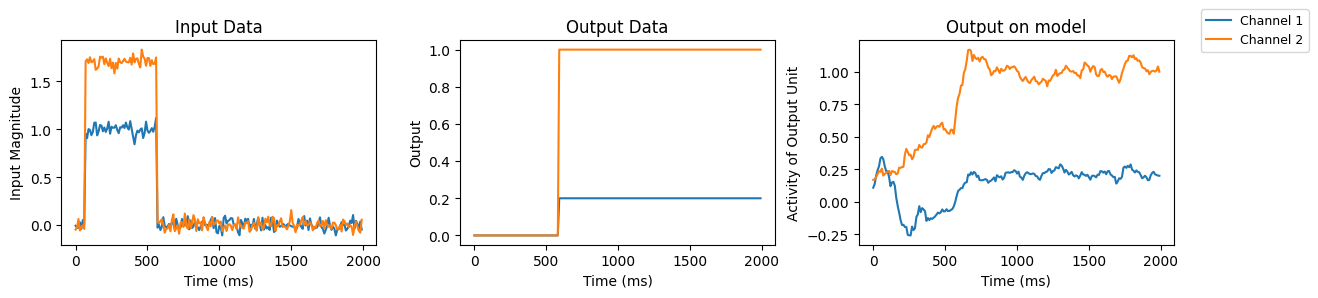

In [5]:
import matplotlib.pyplot as plt

idx = 100
time_input = range(0, len(test_inputs.cpu().numpy()[:,idx,:])*dt, dt)
time_output = range(0, len(test_outputs.cpu().numpy()[:,idx,:])*dt, dt)
time_target = range(0, len(test_targets.cpu().numpy()[:,idx,:])*dt, dt)
print(f"coherece={trial_params[idx]['coherence']}")

# 横排三个子图
fig, axes = plt.subplots(1, 3, figsize=(12,3), sharey=False)

# ========== 第一张 Input ==========
axes[0].plot(time_input, test_inputs.cpu().numpy()[:,idx,:])
axes[0].set_ylabel("Input Magnitude")
axes[0].set_xlabel("Time (ms)")
axes[0].set_title("Input Data")

# ========== 第二张 Output ==========
axes[2].plot(time_output, test_outputs.cpu().numpy()[:,idx,:])
axes[2].set_ylabel("Activity of Output Unit")
axes[2].set_xlabel("Time (ms)")
axes[2].set_title("Output on model")

# ========== 第三张 Target ==========
axes[1].plot(time_target, test_targets.cpu().numpy()[:,idx,:])
axes[1].set_ylabel("Output")
axes[1].set_xlabel("Time (ms)")
axes[1].set_title("Output Data")

# ========== 统一图例 ==========
# 用 handles+labels 取自最后一个 axes
handles, labels = axes[2].get_legend_handles_labels()
if not handles:
    # 如果没有 legend，直接用固定名称
    handles = [plt.Line2D([0], [0], color='C0'),
               plt.Line2D([0], [0], color='C1')]
    labels = ["Channel 1", "Channel 2"]

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=9)

plt.tight_layout()
plt.show()



## single neuro

Text(0, 0.5, 'Activity')

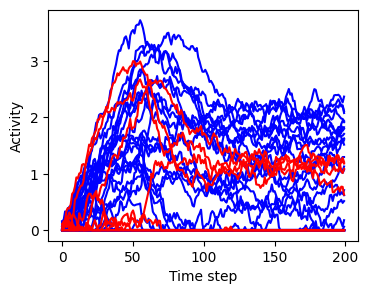

In [6]:
import matplotlib.pyplot as plt

e_size = net.rnn.e_size
trial = idx  # 选择一个 trial 进行可视化
rnn_activity_ = rnn_activity.cpu().numpy()
plt.figure(figsize=(4, 3))
_ = plt.plot(rnn_activity_[:,trial, :e_size], color='blue', label='Excitatory')
_ = plt.plot(rnn_activity_[:,trial, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

## psychometric curve

In [7]:
cohs = np.array([trial['coherence'] for trial in trial_params])
dirs = np.array([trial['direction'] for trial in trial_params])
dirs[dirs==0] = -1
signed_coh = cohs * dirs
print("signed coherence for trials:", signed_coh[:10])

signed coherence for trials: [ 0.5  -0.1  -0.   -0.3  -0.5  -0.5   0.1   0.05  0.05  0.1 ]


In [8]:
import numpy as np
import matplotlib.pyplot as plt

x_test_np = x_test.copy()       # (T, B, 2)
y_test_np = y_test.copy()         # (T, B, 2)
mask_test_np = mask_test.copy()  # (T, B, 2)
outputs_np = test_outputs.permute(1, 0, 2).cpu().numpy()  # (T, B, 2)

# 取出 signed coherence
coherence_levels = np.array([trial['coherence'] for trial in trial_params])
directions = np.array([trial['direction'] for trial in trial_params])
directions[directions==0] = -1
signed_coherence = coherence_levels * directions  # shape (B,)

# 最终 choice
choices = np.argmax((outputs_np * mask_test_np).mean(axis=1), axis=1)


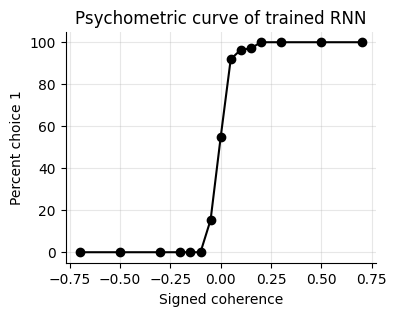

In [9]:
# ==============================
# 统计 psychometric curve
# ==============================
unique_coherences = np.sort(np.unique(signed_coherence))
percent_choice1 = []

for coh in unique_coherences:
    idx = np.where(signed_coherence == coh)[0]
    if len(idx) > 0:
        p = (choices[idx] == 1).mean() * 100
    else:
        p = np.nan
    percent_choice1.append(p)

# ==============================
# 画图
# ==============================
plt.figure(figsize=(4,3))
plt.plot(unique_coherences, percent_choice1, 'ko-', markersize=6)
plt.xlabel('Signed coherence')
plt.ylabel('Percent choice 1')
plt.title('Psychometric curve of trained RNN')
plt.ylim(-5, 105)
plt.grid(alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# plt.savefig(f'{save_path}{mode}_Psychometric_curve.png', dpi=300, bbox_inches='tight')
# plt.show()

## plot seletivity 

In [10]:
def compute_sorted_indices(rnn_activity_, directions, e_size, mode=None,top_e=20, top_i=5):
    """
    根据神经元对刺激的选择性 (d')，返回用于可视化的神经元索引。
    
    参数:
    - rnn_activity_: numpy array, shape (time, batch, hidden_size)
    - directions: list/array of length batch, 包含-1 (choice1) 或 +1 (choice2)
    - e_size: int, excitatory 单元的数量
    - mode: str, 'no_dale' / 'dale' / 'block'
    
    返回:
    - ind_sort: numpy array, 排序后的神经元索引
    """
    stim_activity = [[], []]
    for i, d in enumerate(directions):
        if d == -1:
            stim_activity[0].append(rnn_activity_[:, i, :])
        elif d == 1:
            stim_activity[1].append(rnn_activity_[:, i, :])

    mean_activity = []
    std_activity = []
    for gt in [0, 1]:
        activity = np.concatenate(stim_activity[gt], axis=0)  # (samples, H)
        mean_activity.append(np.mean(activity, axis=0))
        std_activity.append(np.std(activity, axis=0))

    selectivity = (mean_activity[0] - mean_activity[1])
    selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

    if mode == 'none':
        top_n = 25
        abs_SI = np.abs(selectivity)
        ind_top = np.argsort(-abs_SI)[:top_n]
        ind_sort = ind_top[np.argsort(-selectivity[ind_top])]
    elif mode in ['dense', 'block']:
        top_n_e = top_e
        top_n_i = top_i

        abs_SI_e = np.abs(selectivity[:e_size])
        abs_SI_i = np.abs(selectivity[e_size:])

        ind_top_e = np.argsort(-abs_SI_e)[:top_n_e]
        ind_sort_e = ind_top_e[np.argsort(-selectivity[ind_top_e])]

        ind_top_i = np.argsort(-abs_SI_i)[:top_n_i] + e_size
        ind_sort_i = ind_top_i[np.argsort(-selectivity[ind_top_i])]

        ind_sort = np.concatenate([ind_sort_e, ind_sort_i])
    else:
        raise ValueError(f"Unknown mode: {mode}")
    
    return ind_sort, selectivity


Text(0.5, 1.0, 'Network connectivity')

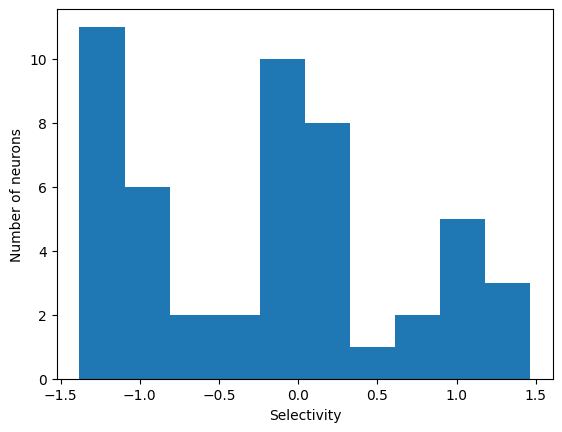

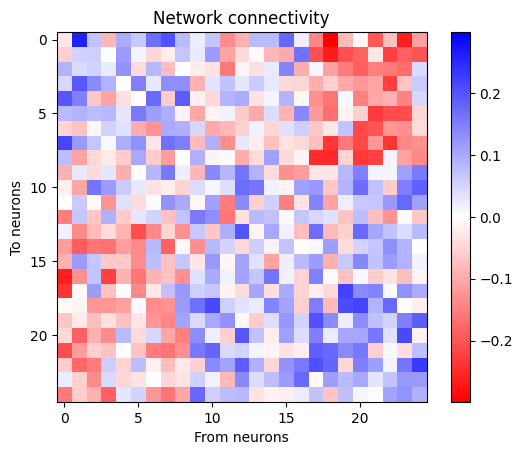

In [11]:
ind_sort, selectivity = compute_sorted_indices(rnn_activity_, directions, e_size, mode=mode, top_e=20, top_i=5)
# ind_sort_ = ind_sort
# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')
# plt.savefig(f'{save_path}{mode}_Selectivity.png', dpi=300, bbox_inches='tight')

W = net.rnn.h2h.effective_weight().detach().cpu().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

## selectivity single neuron

Text(0.5, 1.0, 'Output Data')

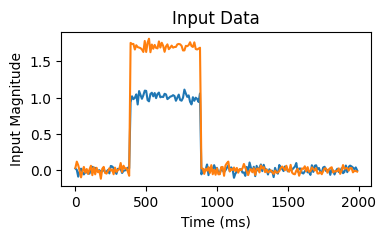

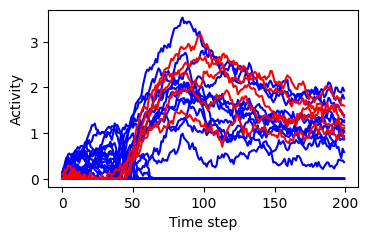

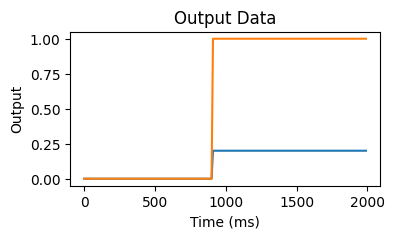

In [12]:
##  选择性调整的 单个神经元活动
idx = 129
time_input = range(0, len(test_inputs.detach()[:,idx,:])*dt, dt)
time_output = range(0, len(test_outputs.detach()[:,idx,:])*dt, dt)
time_target = range(0, len(test_targets.detach()[:,idx,:])*dt, dt)

plt.figure(figsize=(4, 2))
plt.plot(time_input, test_inputs.cpu().numpy()[:,idx,:])
plt.ylabel("Input Magnitude")
plt.xlabel("Time (ms)")
plt.title("Input Data")


plt.figure(figsize=(4, 2.3))
_ = plt.plot(rnn_activity_[:,idx, ind_sort[:20]], color='blue', label='Excitatory')
_ = plt.plot(rnn_activity_[:,idx, ind_sort[20:]], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

plt.figure(figsize=(4, 2))
plt.plot(time_target, test_targets.cpu().numpy()[:,idx,:])
plt.ylabel("Output")
plt.xlabel("Time (ms)")
plt.title("Output Data")

## selectivity neuron population 

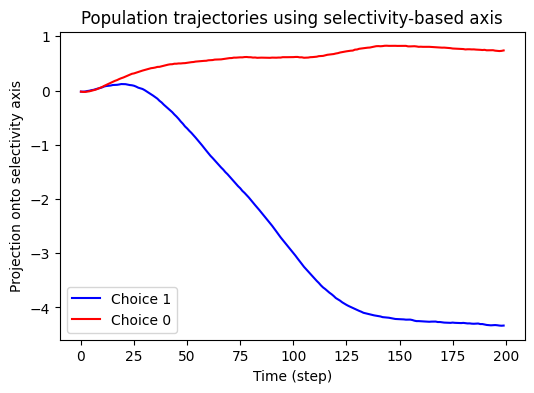

In [13]:
ind_sort, selectivity = compute_sorted_indices(rnn_activity_, directions, e_size, mode=mode, top_e=20, top_i=5)

# 直接用 selectivity 作为投影方向
choice_axis = selectivity / (np.linalg.norm(selectivity)+1e-7)
proj = np.einsum('tnb,b->tn', rnn_activity_, choice_axis)

# 分 choice 平均
idx_choice1 = np.where(choices==1)[0]
idx_choice0 = np.where(choices==0)[0]

mean_traj_choice1 = np.mean(proj[:, idx_choice1], axis=1)
mean_traj_choice0 = np.mean(proj[:, idx_choice0], axis=1)

# 画图
plt.figure(figsize=(6,4))
plt.plot(mean_traj_choice1, label='Choice 1', color='blue')
plt.plot(mean_traj_choice0, label='Choice 0', color='red')
plt.xlabel("Time (step)")
plt.ylabel("Projection onto selectivity axis")
plt.title("Population trajectories using selectivity-based axis")
plt.legend()

# plt.savefig(f'{save_path}{mode}_dynamics_by_selec.png', dpi=300, bbox_inches='tight'
plt.show()


## selectivity neuron population + PCA

In [14]:
ind_sort, selectivity = compute_sorted_indices(rnn_activity_, directions, e_size, mode=mode, top_e=20, top_i=5)
top_n = 20
activity_top = rnn_activity_[:,:, ind_sort[:top_n]]
trial_stim_activity = []
for i in range(rnn_activity_.shape[1]):
    onset_idx = int(trial_params[i]['onset_time'] / dt)
    offset_idx = onset_idx + int(trial_params[i]['stim_duration'] / dt)
    trial_activity = activity_top[onset_idx:offset_idx, i, :]  # (stim_time, top_n)
    trial_stim_activity.append(trial_activity)
X = np.concatenate(trial_stim_activity, axis=0)  

In [15]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
proj = np.einsum('tnb,bk->tnk', activity_top, pca.components_.T)  # (time, trials, 3)


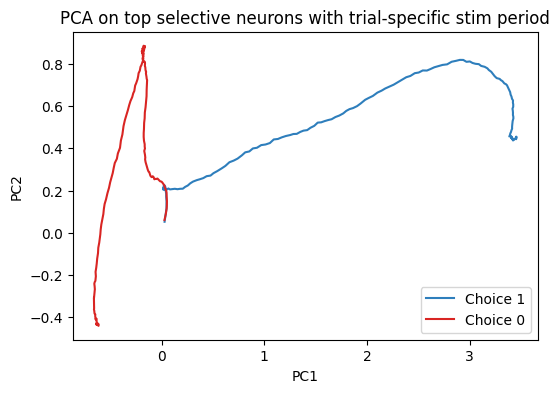

In [16]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

mean_traj_c1 = np.mean(proj[:, choices==1, :], axis=1)
mean_traj_c0 = np.mean(proj[:, choices==0, :], axis=1)

plt.figure(figsize=(6,4))
plt.plot(mean_traj_c1[:,0], mean_traj_c1[:,1], label='Choice 1', color=cm.Blues(0.7))
plt.plot(mean_traj_c0[:,0], mean_traj_c0[:,1], label='Choice 0', color=cm.Reds(0.7))
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA on top selective neurons with trial-specific stim period')
plt.legend()
# plt.savefig(f'{save_path}{mode}_dynamics_mean.png', dpi=300, bbox_inches='tight'
plt.show()

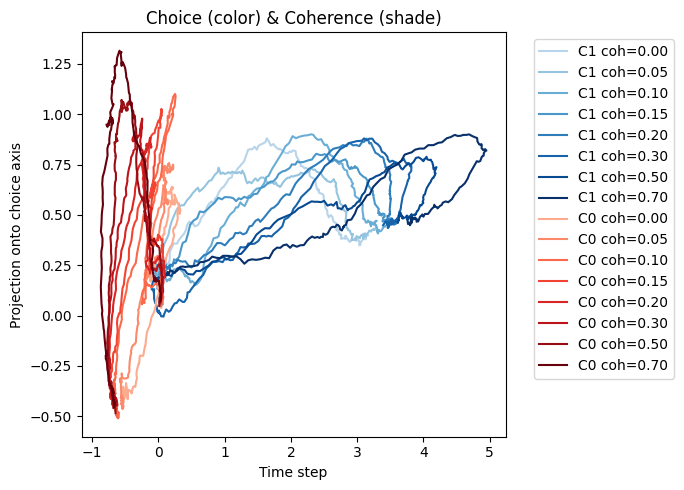

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

coherences = np.array([p['coherence'] for p in trial_params])
unique_coherences = sorted(np.unique(coherences))
colors_c1 = cm.Blues(np.linspace(0.3, 1, len(unique_coherences)))
colors_c0 = cm.Reds(np.linspace(0.3, 1, len(unique_coherences)))

plt.figure(figsize=(7,5))

for coh, color in zip(unique_coherences, colors_c1):
    idx = np.where((coherences == coh) & (choices == 1))[0]
    if len(idx) > 0:
        mean_traj = np.mean(proj[:, idx], axis=1)
        plt.plot(mean_traj[:,0], mean_traj[:,1], color=color, label=f"C1 coh={coh:.2f}")

for coh, color in zip(unique_coherences, colors_c0):
    idx = np.where((coherences == coh) & (choices == 0))[0]
    if len(idx) > 0:
        mean_traj = np.mean(proj[:, idx], axis=1)
        plt.plot(mean_traj[:,0], mean_traj[:,1], color=color, linestyle='-', label=f"C0 coh={coh:.2f}")

plt.xlabel('Time step')
plt.ylabel('Projection onto choice axis')
plt.title('Choice (color) & Coherence (shade)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# plt.savefig(f'{save_path}{mode}_dynamics_by_coh.png', dpi=300, bbox_inches='tight'
plt.show()

## plot connection

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

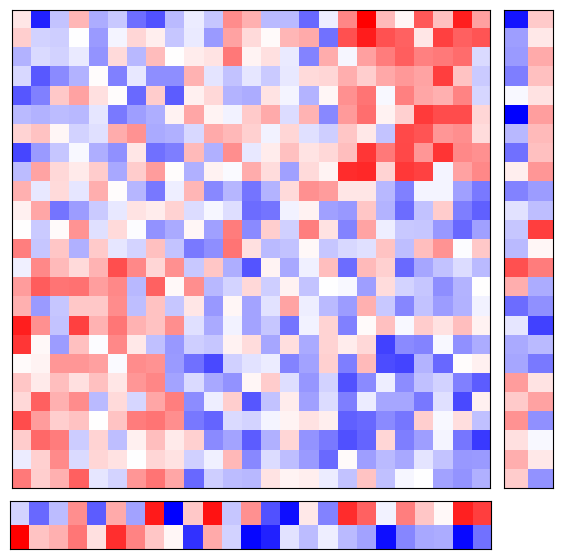

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

len_E = np.sum(ind_sort < net.rnn.e_size)  # 在 ind_sort 中 excitatory 的数量
e_cut = len_E - 0.5

# ==============================
# 1️⃣ Recurrent weight 矩阵
# ==============================
W_rec_full = net.rnn.h2h.effective_weight().detach().cpu().numpy()  # (H,H)
W_rec = W_rec_full[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W_rec))

# ==============================
# 2️⃣ Readout 权重 (output_size, E)
# ==============================
W_fc_full = net.fc.weight.detach().cpu().numpy()  # (2, e_size)
if mode != 'none':
    W_readout = np.zeros((2, len(ind_sort))) * np.nan
    for i in range(2):
        W_readout[i, :len_E] = W_fc_full[i, ind_sort[:len_E]]
    W_readout_sorted = np.abs(W_readout.T)
else:
    W_readout_sorted = W_fc_full[:, ind_sort].T

# ==============================
# 3️⃣ Input 权重 (H, input_size)
# ==============================
W_input = net.rnn.input2h.weight.detach().cpu().numpy()
if mode != 'none':
    W_input_sorted = np.abs(W_input[ind_sort, :].T)
else:
    W_input_sorted = W_input[ind_sort, :].T

# ==============================
# 4️⃣ Plot
# ==============================
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(2,2, width_ratios=[20,2], height_ratios=[20,2], wspace=0.05, hspace=0.05)

# 主 recurrent
ax_main = plt.subplot(gs[0,0])
im = ax_main.imshow(W_rec, cmap='bwr_r', vmin=-wlim, vmax=wlim)
# plt.colorbar(im, ax=ax_main, fraction=0.046, pad=0.04)
ax_main.set_xticks([])
ax_main.set_yticks([])

# excitatory/inhibitory 分界线
ax_main.axvline(net.rnn.e_size-0.5, color='k', linewidth=1)
ax_main.axhline(net.rnn.e_size-0.5, color='k', linewidth=1)

# 右 readout 条带
ax_side = plt.subplot(gs[0,1], sharey=ax_main)
ax_side.imshow(W_readout_sorted, cmap='bwr_r', aspect='auto', 
               vmin=-np.nanmax(W_readout_sorted), vmax=np.nanmax(W_readout_sorted))
# ax_side.axis('off')
ax_side.set_xticks([])
ax_side.set_yticks([])

# 下 input 条带
ax_bottom = plt.subplot(gs[1,0], sharex=ax_main)
ax_bottom.imshow(W_input_sorted, cmap='bwr_r', aspect='auto', 
                 vmin=-np.nanmax(W_input_sorted), vmax=np.nanmax(W_input_sorted))
# ax_bottom.axis('off')
ax_bottom.set_xticks([])
ax_bottom.set_yticks([])

# 右下空
ax_empty = plt.subplot(gs[1,1])
ax_empty.axis('off')

# plt.savefig(f'{save_path}{mode}_connection.png', dpi=300, bbox_inches='tight'

## eigenvalue_spectrum

Text(0.5, 1.0, 'Eigenvalue spectrum of W_rec')

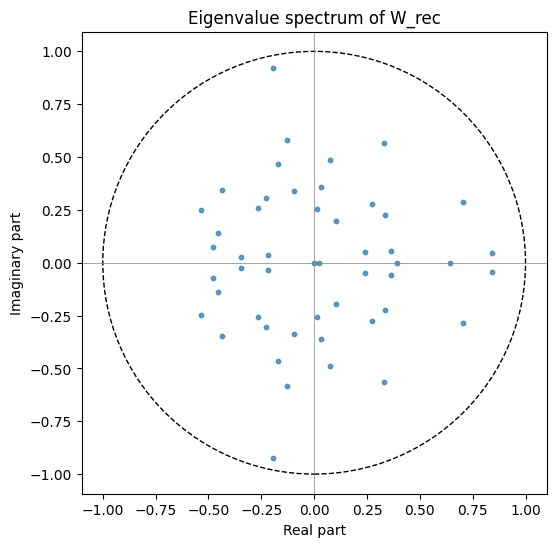

In [19]:
import numpy as np
import matplotlib.pyplot as plt

eigvals = np.linalg.eigvals(W_rec_full)

plt.figure(figsize=(6,6))
plt.scatter(eigvals.real, eigvals.imag, s=10, alpha=0.7)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)

# add complete unit circle
from matplotlib.patches import Circle
circle = Circle((0,0), radius=1, edgecolor='black', facecolor='none',
                linestyle='--', linewidth=1)
plt.gca().add_patch(circle)

plt.axis('equal')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title("Eigenvalue spectrum of W_rec")

# plt.savefig(f'{save_path}{mode}_eigenvalue_spectrum.png', dpi=300, bbox_inches='tight')
# plt.show()

In [20]:
print(f"Spectral radius: {np.max(np.abs(eigvals)):.3f}")
print(f"Largest real part: {np.max(eigvals.real):.3f}")
print(f"Largest im part: {np.max(np.abs(eigvals.imag)):.3f}")

Spectral radius: 0.942
Largest real part: 0.841
Largest im part: 0.922


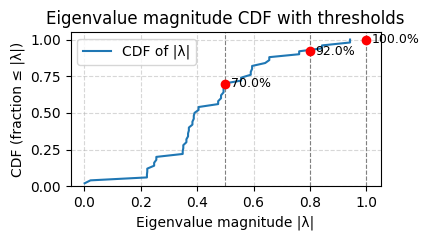

In [21]:
thresholds=[0.5, 0.8, 1.0]
# Compute magnitudes and sort
radii = np.abs(eigvals)
sorted_r = np.sort(radii)
cdf = np.arange(1, len(sorted_r)+1) / len(sorted_r)

plt.figure(figsize=(4,2))
plt.plot(sorted_r, cdf, label='CDF of |λ|')

# Plot markers for thresholds
for t in thresholds:
    fraction = np.searchsorted(sorted_r, t, side='right') / len(sorted_r)
    plt.axvline(t, color='grey', linestyle='--', linewidth=0.8)
    plt.plot([t], [fraction], 'ro')
    plt.text(t+0.02, fraction, f"{fraction*100:.1f}%", va='center', fontsize=9)

plt.xlabel("Eigenvalue magnitude |λ|")
plt.ylabel("CDF (fraction ≤ |λ|)")  #|λ| thresholds to mark on the CDF.
plt.title("Eigenvalue magnitude CDF with thresholds")
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1.05)
plt.legend()

# plt.savefig(f'{save_path}{mode}_eigenvalue_CDF.png', dpi=300, bbox_inches='tight')
# plt.show()